In [1]:
# import pyuvsim
import pyuvdata
import pyradiosky
import astropy
import numpy as np
import importlib
# importlib.reload(pyuvsim)
from astropy.units import Quantity
import matplotlib.pyplot as plt
import sys
sys.path.append("/Users/ruby/Astro/decorrelation")
import decorr_calculations
import coordinate_transforms

In [2]:
uv = pyuvdata.UVData()
uv.read(
    "/Users/ruby/Astro/decorr_sims/20250613_070132_55MHz.ms"
)  # Choose an arbitrary data file for reference

# Set antenna positions
antpos = np.zeros_like(uv.telescope.antenna_positions)
antpos[1, 0] = 3000  # Baseline length
antpos_ecef = pyuvdata.utils.ECEF_from_ENU(antpos, center_loc=uv.telescope.location)
telescope_ecef_xyz = Quantity(uv.telescope.location.geocentric).to_value("m")
uv.telescope.antenna_positions  = antpos_ecef - telescope_ecef_xyz

freq_hz = 50e6
channel_width = 2e3
total_time_interval_s = 10
total_freq_interval_hz = 200e3
integration_time = 0.1
time_array_s = np.arange(-total_time_interval_s/2, total_time_interval_s/2, integration_time)
uv.freq_array = np.arange(freq_hz-total_freq_interval_hz/2, freq_hz+total_freq_interval_hz/2, channel_width)
uv.Nfreqs = len(uv.freq_array)
uv.time_array = np.mean(uv.time_array) + time_array_s/86400
uv.Ntimes = len(time_array_s)
uv.Nbls = 1
uv.Nblts = uv.Ntimes
uv.Npols = 1
uv.Nants_data = 2
uv.Nspws = 1
uv.flex_spw_id_array = np.full(uv.Nfreqs, np.mean(uv.spw_array), dtype=int)
uv.ant_1_array = np.zeros(uv.Nblts, dtype=int)
uv.ant_2_array = np.ones(uv.Nblts, dtype=int)
uv.channel_width = np.full(uv.Nfreqs, channel_width)
uv.integration_time = np.full(uv.Nblts, integration_time)
uv.baseline_array = np.full(uv.Nblts, 2048 + 2**16)
uv.data_array = np.zeros((uv.Nblts, uv.Nfreqs, uv.Npols), dtype=complex)
uv.flag_array = np.zeros((uv.Nblts, uv.Nfreqs, uv.Npols), dtype=bool)
uv.nsample_array = np.ones((uv.Nblts, uv.Nfreqs, uv.Npols), dtype=float)
uv.polarization_array = np.array([-5])
uv.set_lsts_from_time_array()
uv.phase_center_app_ra = uv.phase_center_app_ra[:uv.Nblts]
uv.phase_center_app_dec = uv.phase_center_app_dec[:uv.Nblts]
uv.phase_center_frame_pa = uv.phase_center_frame_pa[:uv.Nblts]
uv.phase_center_id_array = uv.phase_center_id_array[:uv.Nblts]
uv.scan_number_array = None
uv.uvw_array = np.zeros((uv.Nblts, 3), dtype=float)
uv.phase_to_time(np.mean(uv.time_array))
# Redefine uvws after phasing
uv.set_uvws_from_antenna_positions()
# uv.uvw_array = np.zeros((uv.Nblts, 3), dtype=float)
# uv.uvw_array[:, 0] = 3e3

# beam = pyuvdata.UVBeam()
# beam.read("/lustre/rbyrne/LWA_10to100_MROsoil_efields.fits")
# beam.select(feeds="e")
# beam.peak_normalize()
# beam_use_freq = 50e6
# use_freq_ind = np.where(beam.freq_array == beam_use_freq)[0]
# beam.data_array[:, :, :, :, :] = beam.data_array[:, :, use_freq_ind, :, :]  # Make the beam frequency-invariant
# beam_list = pyuvsim.BeamList(beam_list=[beam])

ra_offset_vals_deg = np.linspace(-60, 60, num=11)
dec_offset_vals_deg = np.linspace(-52, 52, num=11)
ra_vals_expanded, dec_vals_expanded = np.meshgrid(ra_offset_vals_deg, dec_offset_vals_deg)
ra_offset_vals_flattened = ra_vals_expanded.flatten()
dec_offset_vals_flattened = dec_vals_expanded.flatten()
source_coords = []
for ind in range(len(ra_offset_vals_flattened)):
    new_coords = astropy.coordinates.SkyCoord([astropy.coordinates.ICRS(
        ra=np.mean(uv.lst_array)*astropy.units.rad + ra_offset_vals_flattened[ind]*astropy.units.deg, 
        dec=uv.telescope.location.lat + dec_offset_vals_flattened[ind]*astropy.units.deg
    )])
    source_coords.append(new_coords)

Setting telescope_location to value in known_telescopes for OVRO-LWA.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 4024.3753728916645 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.


In [3]:
zenith_ra = np.mean(uv.lst_array)*astropy.units.rad
print(zenith_ra)
zenith_dec = uv.telescope.location.lat
print(zenith_dec.to(astropy.units.rad))

4.345053255577194 rad
0.649957 rad


In [4]:
print(source_coords[0])

<SkyCoord (ICRS): (ra, dec) in deg
    [(188.9532133, -14.76022273)]>


In [5]:
ra_offset_vals_flattened[0]

-60.0

In [6]:
dec_offset_vals_flattened[0]

-52.0

In [7]:
print(source_coords[0].ra - np.mean(uv.lst_array) * astropy.units.rad)
print(source_coords[0].dec - uv.telescope.location.lat)

[-60d00m00s]
[-52d00m00s]


In [8]:
uv.telescope.location.lat.rad

0.6499567260882986

In [9]:
decorr_sim = pyuvdata.UVData()
decorr_sim.read("/Users/ruby/Astro/decorr_sims/source001.uvfits")
decorr_sim.unproject_phase()

In [10]:
np.shape(decorr_sim.data_array)

(100, 100, 1)

In [11]:
decorr_sim.telescope.location.lat.degree

37.239777270999994

In [12]:
len(decorr_sim.time_array)

100

In [13]:
np.shape(decorr_sim.uvw_array)

(100, 3)

In [14]:
decorr_sim.telescope

In [15]:
central_time = np.sort(decorr_sim.time_array)[int(decorr_sim.Ntimes/2)]
central_freq = np.sort(decorr_sim.freq_array)[int(decorr_sim.Nfreqs / 2)]
decorr_sim_central_sample = decorr_sim.select(
    times=central_time,
    frequencies=central_freq,
    inplace=False,
)

In [16]:
n_freq_channels = np.arange(0, decorr_sim.Nfreqs, 2)
total_channel_width = n_freq_channels * np.mean(decorr_sim.channel_width)
averaged_vis = np.zeros(len(n_freq_channels), dtype=complex)
decorr_vals_simulated = np.zeros(len(n_freq_channels))
decorr_vals_calculated = np.zeros(len(n_freq_channels))
for ind, chan_width in enumerate(total_channel_width):
    use_n_channels = n_freq_channels[ind]
    use_time = np.sort(decorr_sim.time_array)[int(decorr_sim.Ntimes / 2)]
    use_freqs = np.sort(decorr_sim.freq_array)[
        int(decorr_sim.Nfreqs / 2
        - use_n_channels / 2) : int(decorr_sim.Nfreqs / 2
        + use_n_channels / 2 + 1)
    ]
    data_subset = decorr_sim.select(times=use_time, frequencies=use_freqs, inplace=False)
    averaged_vis[ind] = np.sum(data_subset.data_array) / len(use_freqs)
    decorr_vals_simulated[ind] = 1 - np.abs(averaged_vis[ind]) / np.abs(
        np.sum(decorr_sim_central_sample.data_array)
    )
    decorr_vals_calculated[ind] = decorr_calculations.fractional_freq_decorr(
        chan_width,
        np.mean(decorr_sim.uvw_array[:, 0]),
        np.mean(decorr_sim.uvw_array[:, 1]),
        ra_offset_vals_flattened[0] * 12 / 180,
        dec_offset_vals_flattened[0],
        telescope_lat_deg=decorr_sim.telescope.location.lat.degree,
        c=3e8,
    )

In [17]:
data_single_time = decorr_sim.select(times=use_time, inplace=False)

In [18]:
u = np.mean(decorr_sim.uvw_array[:, 0]) * decorr_sim.freq_array / 3e8
v = np.mean(decorr_sim.uvw_array[:, 1]) * decorr_sim.freq_array / 3e8
l, m = coordinate_transforms.ra_dec_to_l_m(
    source_dec_rad=np.deg2rad(dec_offset_vals_flattened[0]),
    source_ra_offset_rad=np.deg2rad(
        ra_offset_vals_flattened[0]
    ),  # Difference between the source RA and zenith RA
    zenith_dec_rad=np.deg2rad(decorr_sim.telescope.location.lat.degree),
)
visibilities_calculated = np.exp(2 * np.pi * 1j * (l * u + m * v))

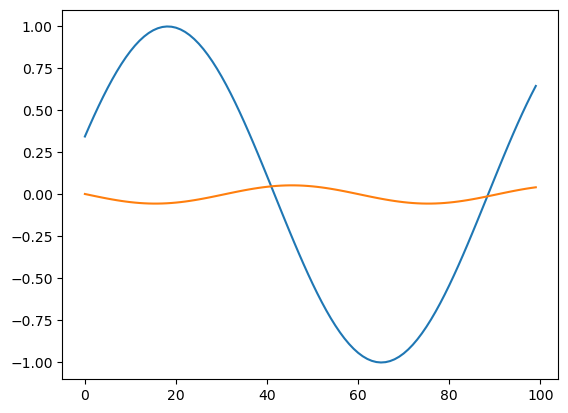

In [19]:
plt.plot(np.imag(visibilities_calculated))
plt.plot(-1*np.imag(data_single_time.data_array.flatten()))

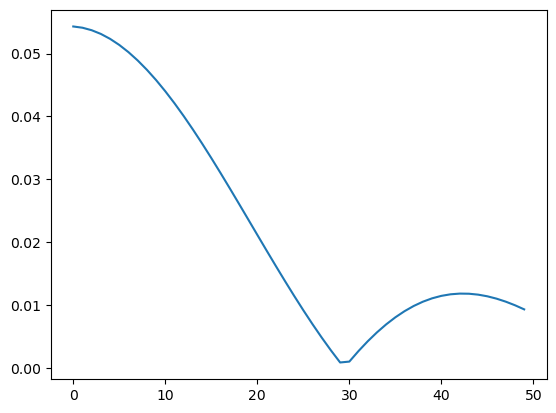

In [20]:
plt.plot(np.abs(averaged_vis))

Text(0, 0.5, 'Decorrelation Fraction')

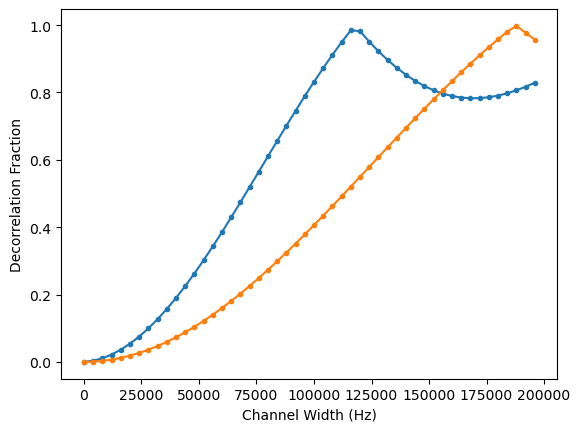

In [21]:
plt.plot(total_channel_width, decorr_vals_simulated, ".-")
plt.plot(total_channel_width, decorr_vals_calculated, ".-")
plt.xlabel("Channel Width (Hz)")
plt.ylabel("Decorrelation Fraction")